# Natural Events and climate change

In this project we will extract data from two sources:

1. EONET API v.2.1

2. Global carbon Atlas http://globalcarbonatlas.org/en/CO2-emissions

## 1. Import Libraries

In [1]:
import pandas as pd
import numpy as np
import re
import math
import requests
import json
import matplotlib
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns
from datetime import datetime

The natural events in the EONET's API are divided in two primarily groups according with their status:

* ```'status' = 'open'``` means the natural event has not ended.

* ```'status' = 'closed'``` means the natural event has finished. When this happen we will have as well an aditional field labeled as closed.

## 2. Data extraction and wrangling

### Extracting data from the EONET's API

In [2]:
#For extracting the category of each natural event

def extract_cat(lista):
    """
    Takes a list of dictionaries and return the value of the first element
    of the list for the key 'title'
    """
    return lista[0]["title"]

# Extracts the date of each natural event
def extract_date(lista):
    """
    Takes a list of dictionaries and return the value of the first element
    of the list for the key 'date'
    """
    return lista[0]["date"]

# Extracts the type of Geojson coordinates of each natural event

def extract_geom(lista):
    """
    Takes a list of dictionaries and removes the key 'date' for the first 
    dictionary
    """
    del lista[0]["date"]
    return lista[0]
    
base = "https://eonet.sci.gsfc.nasa.gov/api/v2.1/events?status=" 

def get_events(st):
    
    """
    Arguments: "open" or "closed"
    Returns a the data set of the events with status "st" 
    which happened since 1980-01-10 until teh current date.
    
    """
    url = base + f"{st}"
    result = requests.get(url)
    
    df_0 = pd.DataFrame(result.json()["events"], columns = ["id", "title", "categories", "description", "sources", "geometries", "closed"])
    df_0.categories = df_0.categories.apply(extract_cat) # Extract category from the original dictionary
    df_0["date"] = df_0.geometries.apply(extract_date)
    df_0["geometries"] = df_0.geometries.apply(extract_geom)
    df_0 = df_0.drop(columns = ["sources"])
    return df_0[['id', 'title', 'categories', 'description', 'date', 'closed','geometries']]


In [3]:
df_op = get_events("open")
df_cl = get_events("closed")

Let us explore our data frames:

In [4]:
df_op.head()

,id,title,categories,description,date,closed,geometries
0,EONET_4493,"Wildfires - Ventura County (Maria Fire), Calif...",Wildfires,,2019-11-01T11:39:00Z,NaN,"{'type': 'Point', 'coordinates': [-119.0570350..."
1,EONET_4492,"Wildfires - Riverside County (46 Fire), Califo...",Wildfires,,2019-10-31T13:39:00Z,NaN,"{'type': 'Point', 'coordinates': [-117.41411, ..."
2,EONET_4488,"Wildfires - Riverside County (Hill Fire), Cal...",Wildfires,,2019-10-30T16:02:00Z,NaN,"{'type': 'Point', 'coordinates': [-117.46421, ..."
3,EONET_4487,"Wildfires - Ventura County (Easy Fire), Califo...",Wildfires,,2019-10-30T13:23:00Z,NaN,"{'type': 'Point', 'coordinates': [-118.8304898..."
4,EONET_4485,Tropical Cyclone Maha,Severe Storms,,2019-10-30T08:46:01Z,NaN,"{'type': 'Point', 'coordinates': [74.8, 8.8]}"


In [5]:
df_cl.head()

,id,title,categories,description,date,closed,geometries
0,EONET_4486,Subtropical Storm Rebekah,Severe Storms,,2019-10-30T00:00:00Z,2019-11-01T00:00:00Z,"{'type': 'Point', 'coordinates': [-40.7, 38.3]}"
1,EONET_4464,Typhoon Bualoi,Severe Storms,,2019-10-19T00:00:00Z,2019-10-30T00:00:00Z,"{'type': 'Point', 'coordinates': [155.1, 10.6]}"
2,EONET_4463,Tropical Storm Neoguri,Severe Storms,,2019-10-17T00:00:00Z,2019-10-27T00:00:00Z,"{'type': 'Point', 'coordinates': [129.9, 19.6]}"
3,EONET_4465,Tropical Storm Nestor,Severe Storms,,2019-10-17T00:00:00Z,2019-10-20T00:00:00Z,"{'type': 'Point', 'coordinates': [-95.2, 22.9]}"
4,EONET_4459,Tropical Cyclone Ema,Severe Storms,,2019-10-12T00:00:00Z,2019-10-19T00:00:00Z,"{'type': 'Point', 'coordinates': [-163.3, 19.6]}"


In [6]:
df_op.dtypes

id              object
title           object
categories      object
description     object
date            object
closed         float64
geometries      object
dtype: object

#### Data wrangling 

**1. Concat data frames:** We want to concatenate both dataframes extracted above. In this way, we obtain all the information of closed and open events:

In [7]:
df_ev = (pd
        .concat([df_op, df_cl], ignore_index=True)
        .sort_values("date", ascending = False)
        .reset_index(drop=True))

df_ev.dtypes

id             object
title          object
categories     object
description    object
date           object
closed         object
geometries     object
dtype: object

**2. Formating data types:** The columns ```'date'``` and ```'closed'``` have no suitable data type. We should correct this field. According with the documentation, most of the fields have Universal Time (UTC) as indicated by the letter Z. with this in mind, we will reformat these fields to YYYY-MM-DD:

In [8]:
df_ev["date"]= pd.to_datetime(df_ev['date'],infer_datetime_format = True).dt.date
df_ev["closed"]= pd.to_datetime(df_ev['closed'],infer_datetime_format = True).dt.date

In [9]:
df_ev["date"]= pd.to_datetime(df_ev['date'],infer_datetime_format = True)
df_ev["closed"]= pd.to_datetime(df_ev['closed'],infer_datetime_format = True)

In [10]:
df_ev.dtypes

id                     object
title                  object
categories             object
description            object
date           datetime64[ns]
closed         datetime64[ns]
geometries             object
dtype: object

**3.Dropping and converting columns to boolean:** We have very little information in the ```'description'``` field (< 4%). Also, in order to do our analysis, this column in not relevant:

In [11]:
len(df_ev[df_ev["description"] != ""]) / len(df_ev)

0.03970621987606151

In [12]:
df_ev = df_ev.drop(columns = "description")

We now that the column ```'closed'``` only contains a date if the event is over. We will condense this information in an extra column with boolean values:

In [13]:
#Create a new column containing the date of end of the event

df_ev["date_closed"] = df_ev["closed"]

# Replace the column closed by a boolean column

df_ev["closed"] = (df_ev["date_closed"].notna())

In [14]:
#Rearranging the columns

df_ev = df_ev[['id', 'title', 'categories', 'date', 'closed', 'date_closed', 'geometries']]

Now our data set looks like:

In [15]:
df_ev.head()

,id,title,categories,date,closed,date_closed,geometries
0,EONET_4493,"Wildfires - Ventura County (Maria Fire), Calif...",Wildfires,2019-11-01,False,NaT,"{'type': 'Point', 'coordinates': [-119.0570350..."
1,EONET_4492,"Wildfires - Riverside County (46 Fire), Califo...",Wildfires,2019-10-31,False,NaT,"{'type': 'Point', 'coordinates': [-117.41411, ..."
2,EONET_4488,"Wildfires - Riverside County (Hill Fire), Cal...",Wildfires,2019-10-30,False,NaT,"{'type': 'Point', 'coordinates': [-117.46421, ..."
3,EONET_4487,"Wildfires - Ventura County (Easy Fire), Califo...",Wildfires,2019-10-30,False,NaT,"{'type': 'Point', 'coordinates': [-118.8304898..."
4,EONET_4485,Tropical Cyclone Maha,Severe Storms,2019-10-30,False,NaT,"{'type': 'Point', 'coordinates': [74.8, 8.8]}"


In [16]:
df_ev.dtypes

id                     object
title                  object
categories             object
date           datetime64[ns]
closed                   bool
date_closed    datetime64[ns]
geometries             object
dtype: object

**4. Exporting dataframe:** Now we export the data in a csv file:

In [17]:
df_ev.to_csv("data/natural_events.csv")

### Collecting data about CO${}_2$ emissions

Here we access data in excel files. The data is available at http://globalcarbonatlas.org/en/CO2-emissions

We obtain data of **territorial CO${}_2$ emissions**, this means Carbon dioxide emissions attributed to the country in which they physically occur.

#### a. CO2 Emissions per country in Million tones

MtCO2 = 1 million tonnes of CO2
To convert between carbon dioxide (CO2) and carbon (C): 3.67 Mt CO2 = 1 Mt C.

In [18]:
emissions_mt = pd.read_excel("data/emissions_mtco2.xlsx")

In [19]:
emissions_mt.head()

,Year,Afghanistan,Albania,Algeria,Andorra,Angola,Anguilla,Antigua and Barbuda,Argentina,Armenia,...,Uruguay,Uzbekistan,Vanuatu,Venezuela,Vietnam,Wallis and Futuna Islands,Western Sahara,Yemen,Zambia,Zimbabwe
0,1960,0.41388,2.0225,6.1512,NaN,0.54895,NaN,0.036640,48.7645,2.4936,...,4.3145,47.8515,NaN,57.0168,7.4839,NaN,NaN,3.6310,4.3552,5.9432
1,1961,0.49080,2.2790,6.0559,NaN,0.45371,NaN,0.047632,51.1267,2.5714,...,4.1168,49.3462,NaN,51.8798,7.9783,NaN,NaN,2.6637,3.7090,5.0613
2,1962,0.68859,2.4622,5.6610,NaN,1.17910,NaN,0.102590,53.6401,2.6987,...,4.0069,51.7895,0.040304,54.0561,9.3377,NaN,NaN,3.8838,3.5827,4.8890
3,1963,0.70674,2.0812,5.4192,NaN,1.14970,NaN,0.084272,50.0327,2.8942,...,4.3148,55.5408,0.032976,56.1517,9.1104,NaN,NaN,2.9165,3.4445,4.7004
4,1964,0.83855,2.0152,5.6430,NaN,1.22290,NaN,0.091600,55.6700,3.0780,...,4.5527,59.0674,0.062288,56.5500,11.7878,NaN,NaN,3.6310,3.2750,4.4691


#### b.CO${}_2$ Emissions per country in kg(CO2) per GDP

Carbon Intensity: Total CO2 emissions divided by GDP.
GDP: Gross Domestic Product, measured in US dollars (USD) at Purchasing Power Parity rates.


In [20]:
emissions_kg = pd.read_excel("data/emissions_kgco2.xlsx")

#### c.CO$_{2}$ Emissions in tonnes per person

CO2 emissions per person are measured as the total CO2 produced by a country as a consequence of human activities and are divided by the population of that country.

In [21]:
emissions_pc = pd.read_excel("data/emissions_tco2.xlsx")

#### d. Land Use Emissions

Carbon dioxide emissions from land use, land use change and forestry (primarily deforestation). Global data values have an uncertainly of ±2 GtCO2 reported as ±1 sigma (68% chance that the real value lies within the given interval). Regional data generally have uncertainty of about ± 50%. For more information see: Section 2.2, Global Carbon Budget 2018, Le Quéré et al. 2018.



In [22]:
land_use = pd.read_excel("data/land_use_change.xlsx")

In [23]:
land_use.head()

,Year,Canada,Caribbean,Central Africa,Central America & Mexico,China,East Africa,East Asia,Europe,Former Soviet Union,NonTropical S. America,North Africa & Middle East,Oceania,South Asia,Southeast Asia,Southern Africa,Tropical S. America,USA,West Africa
0,1960,111.509647,-7.328015,287.091622,139.974901,1301.468612,208.755839,205.477428,56.869953,832.475275,114.200491,11.554995,231.380288,100.093745,487.326822,158.061028,1350.743867,-98.927786,269.014303
1,1961,110.319466,-8.903065,295.720893,170.060460,1212.751133,202.073870,208.500407,56.354318,832.196722,141.607317,8.623399,228.735319,98.334347,483.340468,154.438371,1343.977488,-137.291397,263.487650
2,1962,146.988638,-8.059543,304.491459,153.948059,1139.185983,200.841851,159.365346,44.364428,830.399156,149.706273,3.793679,245.726318,96.744870,453.226283,167.320805,1334.509622,-124.227665,266.015546
3,1963,147.529229,-7.985091,313.286981,152.525934,1056.749709,203.421494,149.295233,40.563776,755.647495,154.647561,1.767472,250.266475,53.597414,442.252616,171.675627,1524.796920,-137.445170,270.049610
4,1964,148.487466,-8.399907,321.843219,160.449464,1046.165429,207.932291,147.606299,36.273179,752.062272,159.267357,1.937393,255.504299,40.956466,443.027353,177.216960,1604.577215,-154.726099,275.848210


We are first interested in global emissions rather than emissions per country. Therefore we aggregate the information for each year in the three dataframes about CO${}_2$ emissions. Notice that we sum up all the emissions in million tones to have global values, while we take the mean of the values in ```emissions_kg``` cause the singular information is in kg/GDP and in ```emissions_pc```cause the singular information is in mt/per capita.

In [24]:
emissions_mt["mt_CO2_global"]= emissions_mt.sum(axis = 1, skipna = True)
emissions_kg["kg_CO2_global"]= emissions_kg.mean(axis = 1, skipna = True)
emissions_pc["pc_CO2_average"]= emissions_pc.mean(axis = 1, skipna = True)

# Filter dataframes with the relevant information
aux_mt = emissions_mt[["Year", "mt_CO2_global"]]
aux_kg = emissions_kg[["Year", "kg_CO2_global"]]
aux_pc = emissions_pc[["Year", "pc_CO2_average"]]

Then we merge the three auxiliary dataframes defined above:

In [25]:
emissions_combined = pd.merge(aux_mt, aux_kg, on= "Year")
emissions_combined = pd.merge(emissions_combined, aux_pc, on ="Year")
#Save the dataframe as csv
emissions_combined.to_csv("data/emissions_CO2.csv")

Finally, we explore the first rows our merged dataset:

In [26]:
emissions_combined.head()

,Year,mt_CO2_global,kg_CO2_global,pc_CO2_average
0,1960,11064.131248,10.594595,13.719937
1,1961,11061.885846,10.543011,13.804837
2,1962,11385.687956,10.436170,13.838856
3,1963,11923.171792,10.386243,14.295206
4,1964,12430.081615,10.229167,14.307196


In order to identify which countries are producing more CO${}_2$ emissions during some year in particular -which is important to go deeper in our project- we should modify someway the original dataset. To this end, we create a function:

In [27]:
def get_data_years(data, n):
    '''
    data is a dataframe in {emissions_mt, emissions_kg, emissions_pg}
    Returns a dataset with country and emissions_(units) as columns
    for years >=n. 
    '''
    data0 = data[data["Year"] >= n].transpose().reset_index()
    data0 = data0.drop(data0.index[0])
    a = 2017-n+1
    data0.columns= ["Country"]+[str(n+i) for i in range(a)]
    return data0
    

For example, suppose we are interested in the top 10 countries with more CO${}_2$ emissions during 2015. We then run:

In [28]:
(get_data_years(emissions_mt, 2015)[["Country", "2015"]]
.sort_values("2015", ascending = False)
.head(11)
)

,Country,2015
221,mt_CO2_global,36188.969071
42,China,9716.467800
210,United States of America,5420.804100
92,India,2276.407200
164,Russian Federation,1671.895100
100,Japan,1223.666500
76,Germany,797.078200
94,Iran,630.361800
173,Saudi Arabia,620.883000
184,South Korea,590.557500


## 2. Analyzing Events per category and year

**1.** We first count the total number of events per category:

In [29]:
df_ev.categories.value_counts()

Severe Storms           1792
Wildfires               1461
Volcanoes                850
Floods                   116
Sea and Lake Ice          58
Dust and Haze             17
Water Color               17
Earthquakes               15
Temperature Extremes      14
Drought                    7
Manmade                    5
Snow                       3
Landslides                 2
Name: categories, dtype: int64

**2.** As the dataset about CO${}_2$ emissions contains data for years, we create a new column in our ```df_ev``` data set containing the year in which the event took place:

In [30]:
#Extracting the year for each entry of the data set. We want the information year by year

df_ev["year"]= df_ev["date"].dt.year

Then we group the events per ```'year'``` and ```'categories'```:

In [31]:
events_per_year_cat = df_ev.groupby(["year", 'categories'])[["id"]].count()
events_per_year_cat.columns = ["no_of_events"]
events_per_year_cat.head()

,,no_of_events
year,categories,
1980,Volcanoes,20
1981,Volcanoes,14
1982,Volcanoes,15
1983,Volcanoes,15
1984,Volcanoes,15


And we also count the total natural events per year:

In [32]:
events_year = (df_ev
              .groupby(["year"])[["id"]]
              .count()
              .reset_index())

In [33]:
#Renaming columns
events_year.columns= ["Year", "Number_of_events"]
events_year.head()

,Year,Number_of_events
0,1980,20
1,1981,14
2,1982,15
3,1983,15
4,1984,15


### Is there any trend of the ocurrence of natural events along the years?

We create a line plot of ```events_year```: 

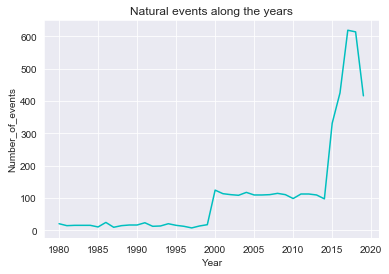

In [34]:
sns.set_style("darkgrid")
sns.lineplot(x="Year", y="Number_of_events", data=events_year, color="c")
plt.title("Natural events along the years");

We can see that since 21${}^{\text{st}}$ century the number of natural events has been increasing. However, this probably is due to the increasing measurement technologies and observation stations. Thus, we filter  the information of events occurred after year 2000.

In [35]:
events_year2000_cat = (df_ev[df_ev["year"] >= 2000]
                       .groupby(["year", 'categories'])[["id"]]
                       .count())

### How is the distribution of events by categories along the years?

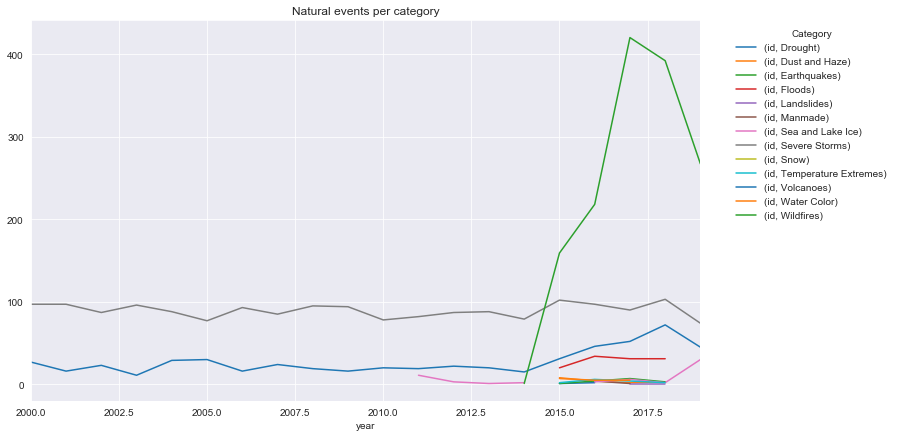

In [36]:
(events_year2000_cat.unstack()
                   .plot(title = "Natural events per category", figsize=(12,7))
                   .legend(bbox_to_anchor=(1.04,1), loc="upper left",frameon= False, title = "Category")
                   .get_figure()
                   .savefig('plots/fig_02.png'))

Since 2014, the most frequent events are Wildfires. However, as we have many categories with similar frequency, in this plot we cannot see easily the behaviour of the less frequent categories along the years. Also, it is not correct to expect that the other categories with less frequencies have not occurred before $21^{\text{st}}$ century. 

Therefore, to have better understanding we plot a heatmap to see the overall distribution of natural events along the years. First we group and aggregate the information in the next dataframe:

In [37]:
by_cat = (df_ev[df_ev["year"]>=2000]
            .groupby(['categories', "year"])
            .size()
            .unstack()
           )

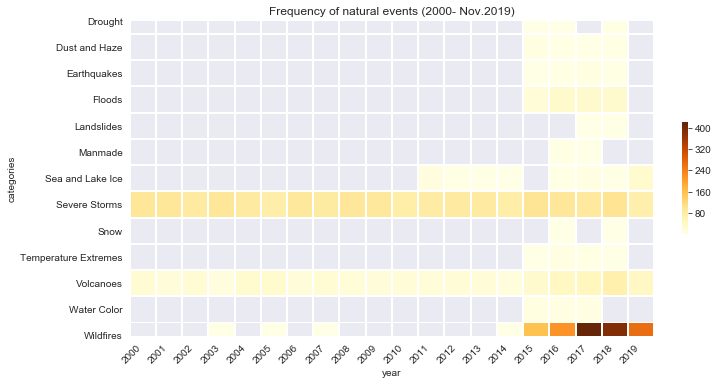

In [38]:
plt.figure(figsize=(10,10))
g = sns.heatmap(
    by_cat, 
    square=True, # make cells square
    cbar_kws={'fraction' : 0.01}, # shrink colour bar
    cmap= "YlOrBr", # use orange/red colour map'YlOrBr'
    linewidth=1 # space between cells
)
g.set_xticklabels(g.get_xticklabels(), rotation=45, horizontalalignment='right')
plt.title("Frequency of natural events (2000- Nov.2019)");

In [39]:
#saving the plot
g.get_figure().savefig("plots/heatmap.png")

#### Conclusion:

From the plot above we see clearly how quickly the Wildfires have increased after 2000. Also we can see that Severe Storms, Droughts, Volcanoes, Floods and Earthquakes are the following most frequent natural events occurred in this century.

## 3. Pairing frequencies of CO${}_2$ global emissions with global counts of natural events

#### Merging data about natural events and CO${}_2$ emissions

We merge now the dataset ```events_year``` containing the aggregation of all natural events since 1980 with ```emissions_combined```:

In [40]:
emissions_events= pd.merge(emissions_combined, events_year, on = "Year")
#Save the dataframe as csv
emissions_events.to_csv("data\emissions_events.csv")
emissions_events.head()

,Year,mt_CO2_global,kg_CO2_global,pc_CO2_average,Number_of_events
0,1980,20928.866204,10.291487,15.560998,20
1,1981,20439.839034,10.184425,14.956099,14
2,1982,20341.079622,10.193283,14.889520,15
3,1983,20530.671032,10.176635,14.484301,15
4,1984,21080.674356,10.206079,15.006519,15


### Emissions CO${}_2$ along the years

We first explore the evolution of CO${}_2$ global emissions along the years:

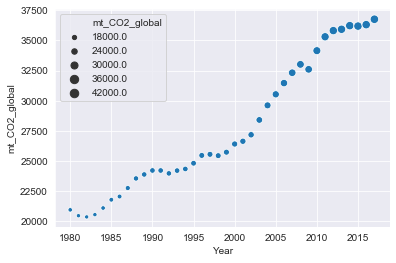

In [41]:
sns.scatterplot(data= emissions_events, y= "mt_CO2_global", x = "Year", size="mt_CO2_global");

We see that, as in the case of occurrences of natural events, the amounts of CO${}_2$ are increasing along the years.

### Is there a correlation between the frequency of natural events and the amount of CO${}_2$ emissions?

To answer this question first we do a scatterplot:

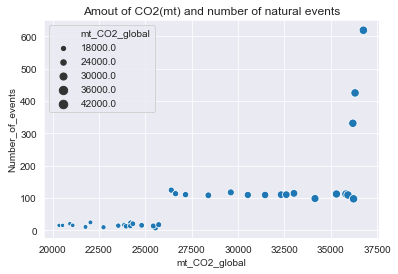

In [42]:
sns.scatterplot(x= "mt_CO2_global", y= "Number_of_events", data=emissions_events, size="mt_CO2_global")
plt.title("Amout of CO2(mt) and number of natural events");

The plot above looks very similar to our first plot showing the evolution of occurrences of natural events along the years. In fact, we can see the behaviour of the three variables in the plot below:

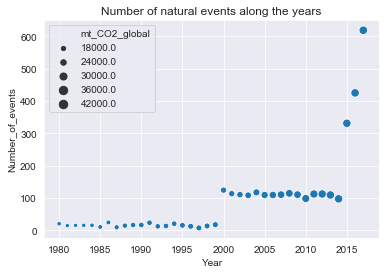

In [43]:
sns.scatterplot(data= emissions_events, y= "Number_of_events", x = "Year", size="mt_CO2_global")
plt.title("Number of natural events along the years");

#### Conclusion:

We see that definitely there is a correlation between global amounts of CO${}_2$ (mt) and the occurrency of natural events. However this correlation is not linear but a functional relation near to a step function.

 ### Which are the 10 countries with most CO${}_2$ emissions (mt) during 2017?  What is the behaviour of CO${}_2$ emissions per capita for these countries?

First we gather the data about CO${}_2$ emissions during 2017 using the function ```get_data_years```:

In [44]:
#Applying clean_data to each emissions_(unit) dataset
dfList= [get_data_years(df, 2017) for df in [emissions_mt, emissions_kg, emissions_pc]]

from functools import reduce

# Using reduce to merge the three datasets at once
data_2017_country = reduce(lambda x, y: pd.merge(x, y, on = 'Country'), dfList)

#Rename the columns
data_2017_country.columns= ["Country", "emissions_mt", "emissions_kg/gdp", "emissions_pc"]

In [45]:
#Sorting the dataframe by ```emissions_mt``` in descending order:
data_2017_country= data_2017_country.sort_values("emissions_mt", ascending= False)

#saving as .csv file
data_2017_country.to_csv("data\emissions_CO2_2017.csv")

data_2017_country.head()

,Country,emissions_mt,emissions_kg/gdp,emissions_pc
41,China,9838.7540,0.476581,6.980229
209,United States of America,5269.5295,0.305913,16.240949
91,India,2466.7654,0.294271,1.841997
163,Russian Federation,1692.7948,0.537713,11.756356
99,Japan,1205.0612,0.261871,9.452613


We will describe now the three quantitative variables along 2017:

In [46]:
data_2017_country.describe()

,emissions_mt,emissions_kg/gdp,emissions_pc
count,212.000000,212.000000,212.000000
mean,163.870270,0.171206,5.140073
std,797.721388,0.185137,6.584466
min,0.011696,0.000000,0.048705
25%,1.361725,0.000000,0.868869
50%,9.688750,0.139946,2.844043
75%,63.235250,0.260384,6.839280
max,9838.754000,1.113397,49.182616


Now we visualize the data in an scatterplot to see what is the behaviour between the two variables ```'emissions_pc'``` and ```'emissions_mt'``` for the 10 countries with more CO${}_2$ emissions during 2017:

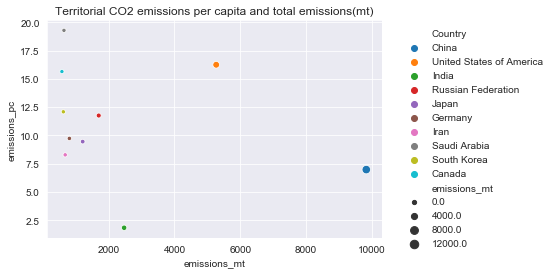

In [47]:
(sns.scatterplot(data= data_2017_country.head(10), y= "emissions_pc", x = "emissions_mt", hue= "Country", size="emissions_mt")
    .legend(bbox_to_anchor=(1.04,1), loc="upper left",frameon= False))
plt.title("Territorial CO2 emissions per capita and total emissions(mt)");

**Conclusion:** Here we see that India, have a relatively small ratio concerning CO2 mt/ CO2 p.c. emissions, while China and US show high emissions per capita of CO2 and high territorial emissions in million tons. So, between the worst performing countries in terms of CO${}_2$ emissions, China and US reflect the worst per-capita indicators.

## 4. Further questions and improvements

#### Analysis considering consumption emissions

In this analysis, we use CO${}_2$ territorial emission data. However there is also data about **consumption CO${}_2$ emissions**, i.e. carbon dioxide emissions occurring anywhere in the world attributed to the country in which goods and services are consumed.

1. How are related the CO2 (consumption) emissions with the occurrence of natural events per Country?

2. Do our findings change if we consider CO2 consumption emissions instead of territorial ones?

#### Analysis of natural events and CO${}_2$ emissions per regions

The geographical location of the natural events in our dataset is given in terms of Geojson coordinates which did not allow us to get easily the stats of natural events for each country along the years. This will be highly desirable in order to pair these values with the CO${}_2$ emissions and to answer the next question:

3. Is there any chance of predict the risk of having natural events from CO2 measurements?

4. How was the occurrence of natural events for the countries producing the majority of CO${}_2$ emissions in the last 10 years?

5. How is the distribution of natural events between regions in the planet? which regions have more incidence of events? Have those regions countries with CO${}_2$ emissions significatively above average?